In [1]:
import torch

In [2]:
!nvidia-smi

Tue Oct  1 16:20:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P3             13W /   30W |     165MiB /   4096MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os 
import requests 

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist downloading")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path
    
    response = requests.get(url)

    if response.status_code == 200:
        with open(filename,'wb') as file:
            file.write(response.content)
        
        print(f"[INFO] the file has been downloaded and saved as {filename}")
    
    else:
        print(f"[INFO] failed to download the file.Status code : {response.status_code}" )

else:
    print("File exists")

File exists


In [4]:
import fitz 
from tqdm import tqdm

def text_formatter(text : str) -> str:
    """Performs minor formatiing on text"""
    cleaned_text = text.replace("\n", " ").strip()
    
    return cleaned_text

def open_and_read_pdf(pdf_path : str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number , page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number" : page_number - 41,
                                "page_char_count" : len(text),
                                "page_word_count" : len(text.split(" ")),
                                "page_sentence_count" : len(text.split(" ")),
                                "page_sentence_count_raw" : len(text.split(". ")),
                                "page_token_counts" : len(text)/4,
                                "text" : text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]
        

1208it [00:01, 611.44it/s]


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_counts': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_counts': 0.0,
  'text': ''}]

In [5]:
import random 
random.sample(pages_and_texts,k=3)

[{'page_number': 103,
  'page_char_count': 954,
  'page_word_count': 178,
  'page_sentence_count': 178,
  'page_sentence_count_raw': 8,
  'page_token_counts': 238.5,
  'text': 'Bronchioles  lead to  alveolar sacs  in the  respiratory  zone, where  gas exchange  occurs.  Gross Anatomy of the Lungs  The lungs are pyramid-shaped, paired organs that are connected  to the trachea by the right and left bronchi; below the lungs is the  diaphragm, a flat, dome-shaped muscle located at the base of the  lungs and thoracic cavity.  Figure 2.18 Basic Anatomy of the Lungs    Each lung is composed of smaller units called lobes. Fissures  separate these lobes from each other. The right lung consists of  three lobes: the superior, middle, and inferior lobes. The left lung  consists of two lobes: the superior and inferior lobes.  Blood Supply  The major function of the lungs is to perform gas exchange, which  requires blood flowing through the lung tissues (the pulmonary  circulation). This blood suppl

In [6]:
import pandas as pd 
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count,page_sentence_count_raw,page_token_counts,text
0,-41,29,4,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,1,0.00,
2,-39,320,54,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [7]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_sentence_count_raw,page_token_counts
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,199.50,10.52,287.00
std,348.86,560.38,95.83,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,216.00,10.00,307.88
75%,864.25,1603.50,272.00,272.00,15.00,400.88
max,1166.00,2308.00,430.00,430.00,39.00,577.00


In [8]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. How are you doing. I like the open space")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., How are you doing., I like the open space]

In [9]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    item["page_sentence_count_spacy"] = len(item["sentences"])
    

  0%|          | 0/1208 [00:00<?, ?it/s]

100%|██████████| 1208/1208 [00:03<00:00, 363.11it/s]


In [10]:
random.sample(pages_and_texts,k=1)

[{'page_number': 1107,
  'page_char_count': 1789,
  'page_word_count': 337,
  'page_sentence_count': 337,
  'page_sentence_count_raw': 26,
  'page_token_counts': 447.25,
  'text': 'Unmodifiable Risk Factors  Modifiable Risk Factors  • Age. Most cancers  occur in people over  the age of sixty-five.  However, people of all  ages, including  children, can get  cancer.  • Family history.  Certain types of  cancer have a genetic  link. However,  environmental factors  may also play a part.  • Tobacco. Smoking or chewing tobacco  greatly increases the risk for certain  cancers, including cancer of the lungs,  bladder, cervix, kidneys, mouth, and  pancreas.  • Alcohol. Drinking alcohol is linked to  cancers of the mouth, throat,  esophagus, and breast, as well as to  cancers of the neck and head.  • Obesity. Linked to cancers of the colon,  uterus, pancreas, esophagus, kidney,  and breast.  • Cooking techniques. Grilling, smoking,  and preparing meat at high  temperatures forms carcinogens.  

In [11]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_sentence_count_raw,page_token_counts,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,430.00,39.00,577.00,28.00


In [12]:
num_sentence_chunk_size = 10

# create a function to split lists of texts recursively into chunk size

def split_list(input_list : list[str], slice_size : int = num_sentence_chunk_size) -> list[list[str]]:
    
    return [input_list[i:i+slice_size] for i in range(0,len(input_list),slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [13]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

100%|██████████| 1208/1208 [00:00<00:00, 241398.79it/s]


In [14]:
random.sample(pages_and_texts,k=3)

[{'page_number': -11,
  'page_char_count': 411,
  'page_word_count': 72,
  'page_sentence_count': 72,
  'page_sentence_count_raw': 3,
  'page_token_counts': 102.75,
  'text': 'Chynna Nicole Chun  Chynna Chun is an undergraduate student majoring in Tropical  Agriculture and the Environment (TAE) with a specialty in plant  production and management at the University of Hawai‘i at Mānoa.  She also serves as a student assistant at the CTAHR Academic and  Student Affairs Office (ASAO) and the 2019-2020 Future Farmers of  America Hawai‘i State Treasurer.  About the Contributors  |  xxxi',
  'sentences': ['Chynna Nicole Chun  Chynna Chun is an undergraduate student majoring in Tropical  Agriculture and the Environment (TAE) with a specialty in plant  production and management at the University of Hawai‘i at Mānoa.',
   ' She also serves as a student assistant at the CTAHR Academic and  Student Affairs Office (ASAO) and the 2019-2020 Future Farmers of  America Hawai‘i State Treasurer.',
   ' A

In [15]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(1)

,page_number,page_char_count,page_word_count,page_sentence_count,page_sentence_count_raw,page_token_counts,page_sentence_count_spacy,num_chunks
count,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0,1208.0
mean,562.5,1148.0,199.5,199.5,10.5,287.0,10.3,1.5
std,348.9,560.4,95.8,95.8,6.5,140.1,6.3,0.6
min,-41.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
25%,260.8,762.0,134.0,134.0,5.0,190.5,5.0,1.0
50%,562.5,1231.5,216.0,216.0,10.0,307.9,10.0,1.0
75%,864.2,1603.5,272.0,272.0,15.0,400.9,15.0,2.0
max,1166.0,2308.0,430.0,430.0,39.0,577.0,28.0,3.0


In [16]:
import re 

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        joined_sentence_chunk = "".join(sentence_chunk).replace("  "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])',r'. \1', joined_sentence_chunk)
        # joined_sentence_chunk = 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4
        
        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 20473.58it/s]


1843

In [17]:
random.sample(pages_and_chunks,k=1)

[{'page_number': 946,
  'sentence_chunk': 'workout four to five days per week, you can become more active in simple ways—by taking the stairs instead of the elevator, by walking more instead of driving, by going out dancing with your friends, or by doing your household chores at a faster pace. It is not necessary to perform at the level of a professional dancer or athlete, or to work out for several hours every day, to see real gains from exercise. Even slightly increased activity can lead to physical benefits, such as: • Longer life. A regular exercise program can reduce your risk of dying early from heart disease, certain cancers, and other leading causes of death. • Healthier weight. Exercise, along with a healthy, balanced eating plan, can help you lose extra weight, maintain weight loss, or prevent excessive weight gain. • Cardiovascular disease prevention. Being active boosts HDL cholesterol and decreases unhealthy triglycerides, which reduces the risk of cardiovascular diseases.

In [18]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(1)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.0,1843.0,1843.0,1843.0
mean,583.4,734.1,112.7,183.5
std,347.8,447.5,71.2,111.9
min,-41.0,12.0,3.0,3.0
25%,280.5,315.0,45.0,78.8
50%,586.0,745.0,115.0,186.2
75%,890.0,1118.0,173.0,279.5
max,1166.0,1830.0,297.0,457.5


In [19]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25


In [20]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunks token count : {row[1]["chunk_token_count"]} | Text : {row[1]["sentence_chunk"]}")

Chunks token count : 4.5 | Text : 516 | Introduction
Chunks token count : 16.5 | Text : Table 4.6 Sweeteners Carbohydrates and Personal Diet Choices | 281
Chunks token count : 29.25 | Text : Abagovomab (monoclonal antibody) by Blake C / CC BY-SA 3.0 Figure 6.13 Antigens Protein’s Functions in the Body | 389
Chunks token count : 23.75 | Text : Unfortunately, a mother’s intention alone may not be enough to make this practice Infancy | 821
Chunks token count : 9.75 | Text : 1002 | The Causes of Food Contamination


In [21]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient = "records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [22]:
random.sample(pages_and_chunks_over_min_token_len,k=1)

[{'page_number': 191,
  'sentence_chunk': 'The chloride AI for adults, set by the IOM, is 2,300 milligrams. Therefore just ⅔ teaspoon of table salt per day is sufficient for chloride as well as sodium. The AIs for other age groups are listed in Table 3.7 “Adequate Intakes for Chloride”. Table 3.7 Adequate Intakes for Chloride Chloride | 191',
  'chunk_char_count': 299,
  'chunk_word_count': 53,
  'chunk_token_count': 74.75}]

# Embedding Creation

In [23]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device="cpu")

sentences = ["This transformer library provides an easy way to create embeddings","Sentence can be embedded one by one or in a list","I like horses!"]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences,embeddings))

for sentence,embedding in embeddings_dict.items():
    print(f"Sentence : {sentence}")
    print(f"Embedding : {embedding}")
    print("")
    

d:\PROGRAMMING\PROJECTS\RAG APPLICATIONS\app\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
d:\PROGRAMMING\PROJECTS\RAG APPLICATIONS\app\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence : This transformer library provides an easy way to create embeddings
Embedding : [-5.86763807e-02  2.15980671e-02 -4.27455269e-03  2.02442892e-02
  1.43263629e-02  2.03130580e-03  5.80121763e-02  5.90883708e-03
 -2.41511152e-03 -2.47064643e-02 -1.19069195e-03  4.40405048e-02
 -3.00784465e-02  4.55406718e-02  3.67805585e-02 -9.44938436e-02
 -1.49355801e-02  2.06775311e-02 -7.01181665e-02 -2.70832051e-02
  4.64058109e-03 -1.04655856e-02  4.00112122e-02  3.38998735e-02
 -3.49714048e-02  1.17343361e-03 -1.77217759e-02 -2.17489563e-02
  5.51169701e-02 -1.80960269e-05 -2.37851478e-02  2.18494721e-02
  5.09840138e-02  1.18556526e-02  1.41775934e-06 -8.48422293e-03
 -1.51468087e-02  3.46255973e-02  3.25772837e-02  4.82234685e-03
  5.04224189e-02 -3.89211997e-02  1.26176365e-02  2.40903173e-04
 -4.10542116e-02 -2.76742633e-02  3.58504206e-02  3.42921764e-02
  9.06183422e-02 -5.53744892e-03 -1.38647472e-02 -4.13199849e-02
  1.26640825e-02 -2.28973050e-02  3.28343399e-02  2.55404692e-02


In [24]:
embeddings[0].shape

(768,)

In [25]:
embedding = embedding_model.encode("My favourite animal is cow")
embedding

array([-9.21416935e-03,  8.87036994e-02, -2.51310132e-02, -2.74914932e-02,
        4.00892012e-02,  4.37048599e-02, -7.65400454e-02,  2.26358231e-02,
        2.73859389e-02, -1.58532057e-02, -5.09625077e-02,  2.64987927e-02,
       -3.43281440e-02,  1.15894629e-02, -2.55632028e-02, -3.71369757e-02,
        3.10210604e-02,  2.41591129e-03, -5.38053690e-03,  2.99286544e-02,
       -1.68309323e-02,  3.75664197e-02, -1.52704716e-02, -2.26567946e-02,
       -5.58478432e-03,  9.41315852e-03, -4.33538575e-03, -3.67277116e-02,
        2.35188417e-02,  2.69529428e-02, -5.05250804e-02, -7.53692910e-02,
        2.36065593e-02, -3.02981697e-02,  1.27883800e-06,  7.88889080e-03,
       -2.41745804e-02,  4.54756850e-03,  4.74361070e-02, -2.27999495e-04,
       -1.05339661e-02,  7.11564021e-03, -5.06195193e-03,  4.93144849e-03,
        5.76684205e-03,  5.59861995e-02,  4.32128645e-02,  8.10807198e-03,
       -7.92747885e-02,  2.30842773e-02, -6.94676582e-03, -3.03875618e-02,
       -2.28618104e-02, -

In [26]:
%%time 

embedding_model.to("cpu")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 1680/1680 [07:18<00:00,  3.83it/s]

CPU times: total: 20min 40s
Wall time: 7min 18s


In [27]:
text_chunks_and_embedding_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embedding_df_save_path = "text_chunks_and_embedding_df.csv"
text_chunks_and_embedding_df.to_csv(embedding_df_save_path,index = False)

In [28]:
text_chunks_and_embedding_df_load = pd.read_csv(embedding_df_save_path)
text_chunks_and_embedding_df_load

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242824e-02 9.02280435e-02 -5.09550655e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156381e-02 5.92138283e-02 -1.66167859e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801637e-02 3.39813344e-02 -2.06427164e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566762e-02 3.81274372e-02 -8.46859161e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264270e-02 -8.49772990e-03 9.57151968e-...
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1304,186,326.00,[ 1.85622890e-02 -1.64279304e-02 -1.27046388e-...
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,[ 3.34721655e-02 -5.70441373e-02 1.51489312e-...
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,[ 7.70513862e-02 9.78544727e-03 -1.21817011e-...
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,[ 1.03045113e-01 -1.64702684e-02 8.26841686e-...


In [29]:
import random 
import torch 
import numpy as np 
import pandas as pd 

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embedding_df.csv")

text_chunks_and_embedding_df['embedding'] = text_chunks_and_embedding_df['embedding'].apply(lambda x : np.fromstring(x.strip("[]"), sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df['embedding'].tolist(),axis=0), dtype=torch.float32)

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")
text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242824, 0.0902280435, -0.00509550655, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156381, 0.0592138283, -0.0166167859, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,"[0.0279801637, 0.0339813344, -0.0206427164, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,"[0.0682566762, 0.0381274372, -0.00846859161, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.033026427, -0.0084977299, 0.00957151968, -0..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1304,186,326.00,"[0.018562289, -0.0164279304, -0.0127046388, -0..."
1676,1164,Hazard Analysis Critical Control Points reused...,374,51,93.50,"[0.0334721655, -0.0570441373, 0.0151489312, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1285,175,321.25,"[0.0770513862, 0.00978544727, -0.0121817011, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,63,102.50,"[0.103045113, -0.0164702684, 0.00826841686, 0...."


In [30]:
embeddings.shape

torch.Size([1680, 768])

In [31]:
from sentence_transformers import util,SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2")


d:\PROGRAMMING\PROJECTS\RAG APPLICATIONS\app\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [39]:
query = "macronutrients functions"
print(f"Query : {query}")

query_embedding = embedding_model.encode(query,convert_to_tensor=True).to(device)

from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"[INFO] time taken to get scores on {len(embeddings)} embeddings : {end_time - start_time:.5f} seconds ")

top_results_dot_product = torch.topk(dot_scores,k = 5)
top_results_dot_product

Query : macronutrients functions
[INFO] time taken to get scores on 1680 embeddings : 0.11713 seconds 


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473]),
indices=tensor([42, 47, 41, 51, 46]))

In [40]:
pages_and_chunks[42]

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

In [41]:
larger_embeddings = torch.randn(100*embeddings.shape[0],768)
print(f"Embeddings shape : {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a = larger_embeddings, b = embeddings)[0]
end_time = timer()

print(f"[INFO] time taken to get scores on {len(larger_embeddings)} embeddings : {end_time - start_time:.5f} seconds ")


Embeddings shape : torch.Size([168000, 768])
[INFO] time taken to get scores on 168000 embeddings : 2.29677 seconds 


In [37]:
larger_embeddings.dtype

torch.float32

In [42]:
import textwrap 

def print_wrapped(text,wrap_length = 80):
    wrapped_text = textwrap.fill(text,wrap_length)
    print(wrap_length)

In [44]:
print(f"Query : {"micronutrients functions"}")
print("Results ")

for score,idx in zip(top_results_dot_product[0],top_results_dot_product[1]):
    print(f"Score : {score:.4f}")
    print("Text : ")
    print(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number : {pages_and_chunks[idx]['page_number']} ")
    print()

Query : micronutrients functions
Results 
Score : 0.6926
Text : 
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are

In [45]:
# to check our result what if we want to autmatically return the surface page of text related to our query

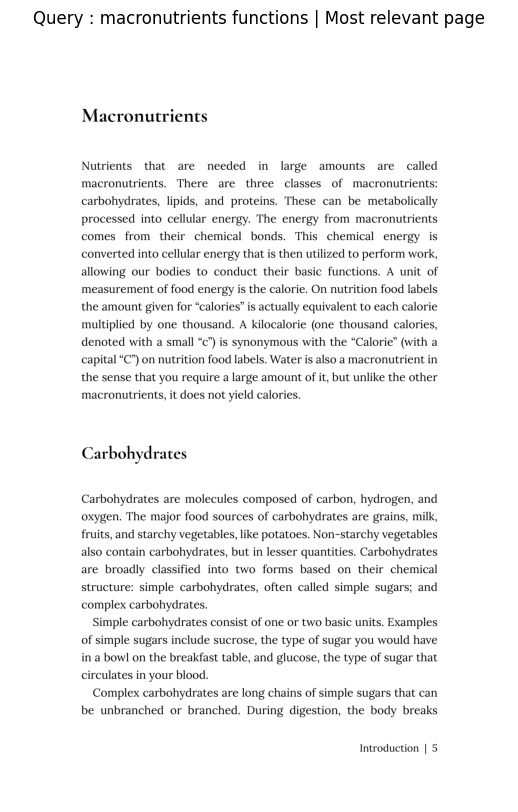

In [49]:
import fitz 
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)

page = doc.load_page(5 + 41)
img = page.get_pixmap(dpi = 300)
doc.close()
# convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8 ).reshape((img.h,img.w,img.n))
# img_array
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query : {query} | Most relevant page")
plt.axis("off")
plt.show()

# Similarity Measure : dot product and cosine similarity

Two of the most common similarty measures between vectors are dot product
and another is cosine where we use the most nearest vector in the search space
which is closer to our query and the direction

In [50]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1677e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1828e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3388e-03, -1.0629e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7492e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4898e-04, -9.9662e-02,  4.9